In [1]:
import kagglehub
import os
import re
import string 
import contractions
import numpy as np
import pandas as pd
import nltk 
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as tm
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.core.module import LightningModule
from pytorch_lightning.callbacks import EarlyStopping 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

nltk.download('punkt_tab')
warnings.filterwarnings("ignore")
stop_words = get_stop_words('en')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\annag\anaconda3\envs\sentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\annag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# EDA

In this part of the analysis, I will conduct a initial data analysis. This section will include a study of the distribution of the target variable, calculation of the number of missing data, clean comments by removing punctuation marks, links, and stopwords. At the end of this part I will tokenize text.

In [2]:
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

train = pd.read_csv(path + '\\twitter_training.csv')
valid = pd.read_csv(path + '\\twitter_validation.csv')

train.columns = ['id', 'entity', 'sentiment', 'tweet']
valid.columns = ['id', 'entity', 'sentiment', 'tweet']

train.head()

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [3]:
# check number of nulls in each column
train[['id', 'entity', 'sentiment', 'tweet']].isnull().sum()

id             0
entity         0
sentiment      0
tweet        686
dtype: int64

In [4]:
valid[['id', 'entity', 'sentiment', 'tweet']].isnull().sum()

id           0
entity       0
sentiment    0
tweet        0
dtype: int64

In [5]:
train.dropna(subset=['tweet'], inplace=True)

In [6]:
def draw_plot(df, name):
    """
    Print distribution plot of sentiment
    """
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue', 'orange']
    df['sentiment'].value_counts().plot(kind='bar', color=colors)

    plt.title(f'Distribution of sentiment ({name} set)')
    plt.ylabel('Count')
    plt.xlabel('Sentiment')
    plt.show()

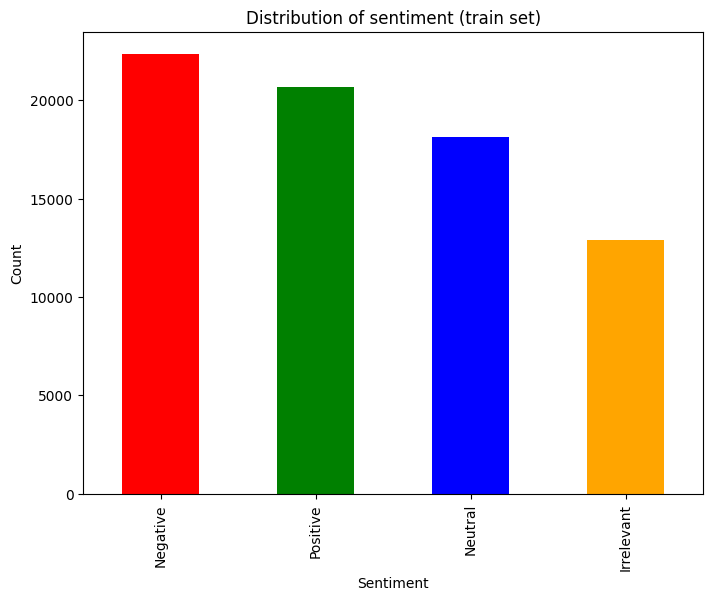

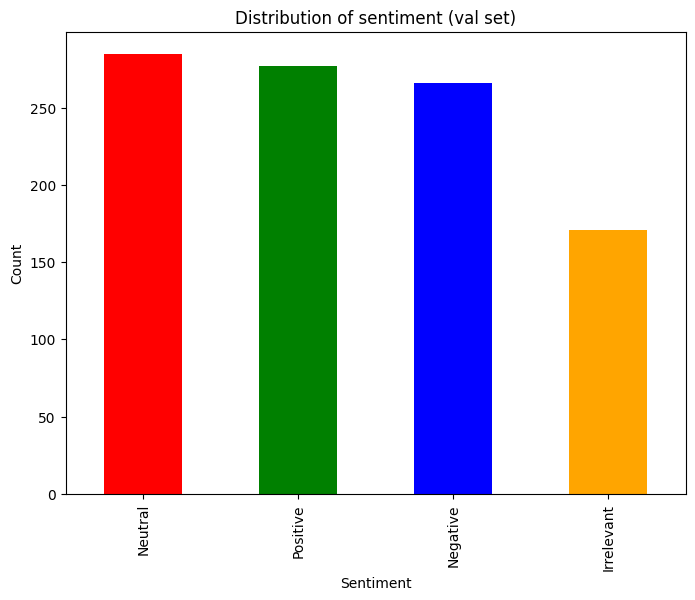

In [7]:
draw_plot(train, 'train')
draw_plot(valid, 'val')

In [8]:
def clean_text(text):
    """
    Clean input text by lowercasing and removing punctuation
    """
    # lower case
    text = text.lower() 
    # remove links
    text = re.compile(r"https?://\S+|www\.\S+").sub("", text)
    # remove punctuations
    table = str.maketrans('','',string.punctuation)
    text = text.translate(table)
    # remove unique char
    text = re.sub(r'(?:^| )\w(?:$| )', ' ',text).strip()
    # contractions
    text = " ".join([contractions.fix(word) for word in text.split()])

    replacements = {
        r"'s\b": "",
        r"\s+": " ",
    }

    for replace, by in replacements.items():
        text = re.sub(replace, by, text)

    return text.strip()

In [9]:
train['tweet_clean'] = train['tweet'].apply(lambda x: clean_text(x))
valid['tweet_clean'] = valid['tweet'].apply(lambda x: clean_text(x))

In [10]:
def remove_stopwords(text):
    """
    Tokenize text and remove stopwords.
    """
    text = text.apply(word_tokenize)
    text = text.apply(lambda x: [word for word in x if word not in stop_words])
    return text

In [11]:
train['tweet_no_stopwords'] = remove_stopwords(train['tweet_clean'])
train['tweet_no_stopwords'] = train['tweet_no_stopwords'].apply(lambda x: ' '.join(eval(str(x))))
valid['tweet_no_stopwords'] = remove_stopwords(valid['tweet_clean'])
valid['tweet_no_stopwords'] = valid['tweet_no_stopwords'].apply(lambda x: ' '.join(eval(str(x))))

# Modelling

In this part of the analysis, I will prepare the data structure for the GRU neural network model. Then, using the PyTorch Lightning package, I will train the model and calculate basic statistics. Finally, I will make predictions with the model and visualize the prediction results using a confusion matrix.

In [12]:
val, test = train_test_split(valid, test_size=0.33, random_state=42)

X_train = train['tweet_no_stopwords']
y_train = train['sentiment']

X_val = val['tweet_no_stopwords']
y_val = val['sentiment']

X_test = test['tweet_no_stopwords']
y_test = test['sentiment']

The DataStructure class is designed to preprocess textual data for deep learning model based on PyTorch. Its primary function is to transform raw text data into a format suitable for neural networks, which involves:

* init: Initializes the class object, storing essential information such as input data (X), labels (y), data type (train/test), and parameters related to data processing.
* encode_data: Encodes text labels using LabelEncoder, assigning a unique integer to each label.
* get_tokenizer: Creates a Tokenizer object, which is used to split text into tokens and assign indices to them.
* tokenize_data: Tokenizes the input data, creating sequences of integers representing individual words, and then pads these sequences to a fixed length.
* tensor_data: Converts tokenized data and encoded labels into PyTorch tensors, creates a TensorDataset object, and wraps it in a DataLoader for convenient access during model training.

In [13]:
# create class for special structure of data
class DataStructure:
    def __init__(self,X,y,typedt,y_train=y_train,X_train=X_train,shuffle=True):
        self.X = X
        self.y_train = y_train
        self.y = y
        self.typedt = typedt
        self.X_train = X_train
        self.shuffle = shuffle

    def encode_data(self):
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(self.y_train)
        y = label_encoder.transform(self.y)
        if self.typedt == 'train':
            return y_train
        elif self.typedt == 'val' or self.typedt == 'test':
            return y
    
    def get_tokenizer(self):
        tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
        tokenizer.fit_on_texts(self.X_train)
        return tokenizer
    
    def tokenize_data(self):
        X_seq = self.get_tokenizer().texts_to_sequences(self.X)
        X_pad = pad_sequences(X_seq, maxlen=50, padding='post')
        return X_pad
    
    def tensor_data(self):
        dataset = TensorDataset(torch.tensor(self.tokenize_data(), dtype=torch.long), torch.tensor(self.encode_data(), dtype=torch.long))
        dataloader = DataLoader(dataset, batch_size=64, shuffle=self.shuffle)
        return dataloader

In [14]:
structure = DataStructure(X_train,y_train,'train',shuffle=True)
dataloader_train = structure.tensor_data()
structure_val = DataStructure(X_val,y_val,'val',shuffle=False)
dataloader_val = structure_val.tensor_data()
structure_test = DataStructure(X_test,y_test,'test',shuffle=False)
dataloader_test = structure_test.tensor_data()

A Gated Recurrent Unit (GRU) is a type of recurrent neural network. Recurrence means the network "remembers" information from 
previous processing steps. In the context of text processing, this implies that a GRU considers not only individual words but 
also the broader context in which they appear.

How does the GRUModel class work?

  1) Word Embedding:
    Initially, each word in our text is represented as a numerical vector. This process is called embedding. The self.embedding layer handles this transformation, converting words from their textual form into a numerical representation that the neural network can understand.

   2) Sequence Processing by GRU:
    Subsequently, the sequence of word vectors is fed into the self.gru layer.
    The GRU is the core component of this network. At each processing step, the GRU receives:
   * The current word vector: Representing the word being processed at that moment.
   * The hidden state: This captures information from all previously processed words, acting as a form of "memory" for the network. Based on this input, the GRU calculates:
   - A new hidden state: This updated state encapsulates the information from the entire sequence processed so far. The GRU selectively "remembers" important information and "forgets" less relevant details.
   - An output: While the GRU can produce an output at each step, in this specific model, we only utilize the final output.

3) Information Extraction:
    After processing the entire sequence of words, the GRU produces a final hidden state. This state contains the most crucial information extracted from the entire text.

4) Generating the Output:
The final hidden state is then passed through additional layers:
* nn.GELU(): This layer introduces non-linearity into the processing, enabling the network to learn more complex relationships.
* nn.Linear(): This layer acts as a classifier. It transforms the hidden state into an output vector, where the dimensions correspond to the number of classes we want to predict.

In [15]:
class GRUModel(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, vocab_size, embedding_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers = 1, bidirectional = False, bias = True, batch_first=True)  
        self.layers = nn.Sequential(
                        nn.GELU(),
                        nn.Linear(hidden_dim, output_dim))
        
    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.gru(embedded) # return tuple not tensor
        out = self.layers(out[:, -1, :])
        return out

In [16]:
vocab_size = 10000
embedding_dim = 64
hidden_dim = 128
output_dim = 4

model_gru = GRUModel(hidden_dim=hidden_dim, output_dim=output_dim, vocab_size=vocab_size, embedding_dim=embedding_dim)
model_gru.to(device)

GRUModel(
  (embedding): Embedding(10000, 64)
  (gru): GRU(64, 128, batch_first=True)
  (layers): Sequential(
    (0): GELU(approximate='none')
    (1): Linear(in_features=128, out_features=4, bias=True)
  )
)

The TrainModel class inherits from LightningModule and utilizes methods such as training_step, validation_step, and test_step to define the individual stages of the training process.
This class consist of:
1) Initialization (__init__)
* Stores the underlying model (self.model).
* Defines loss function (self.criterion as CrossEntropyLoss).
* Initializes metrics for training and validation (accuracy, recall, precision, F1-score).
* Creates a list to store test predictions (self.test_preds).

2) Forward Pass (forward)
* Simply passes the input data through the underlying model (self.model).

3) Training Step (training_step)
* Calculates the loss.
* Updates training metrics (accuracy, recall, precision, F1-score).
* Logs the training loss and metrics.
* Returns the calculated loss.

4) Validation Step (validation_step)
* Calculates the validation loss.
* Updates validation metrics (accuracy, recall, precision, F1-score).
* Logs the validation loss and metrics.

5) Test Step (test_step)
* Predicts the labels for the test data.
* Stores the predicted labels in self.test_preds.

6) Get Test Predictions (get_test_preds)
* Returns a concatenated tensor of all test predictions.

7) Configure Optimizers (configure_optimizers)
* Defines the optimizer (Adam) with a learning rate of 1e-3.

In [17]:
class TrainModel(pl.LightningModule):
  def __init__(self, model): 
    super(TrainModel,self).__init__()
    self.model = model
    self.criterion = nn.CrossEntropyLoss()
    self.train_acc = tm.Accuracy(task='multiclass', num_classes=4)
    self.val_acc = tm.Accuracy(task='multiclass', num_classes=4)
    self.train_recall = tm.Recall(task='multiclass', num_classes=4)
    self.val_recall = tm.Recall(task='multiclass', num_classes=4)
    self.train_precision = tm.Precision(task='multiclass', num_classes=4)
    self.val_precision = tm.Precision(task='multiclass', num_classes=4)
    self.train_f1 = tm.F1Score(task='multiclass', num_classes=4)
    self.val_f1 = tm.F1Score(task='multiclass', num_classes=4)
   
    self.test_preds = []

  def forward(self, x):
        return self.model(x) 
  
  def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, labels)

        self.train_acc(torch.argmax(outputs, dim=1), labels)
        self.train_recall(torch.argmax(outputs, dim=1), labels)
        self.train_precision(torch.argmax(outputs, dim=1), labels)
        self.train_f1(torch.argmax(outputs, dim=1), labels)

        self.log('train_loss', loss.item(), prog_bar=True, logger=True)
        self.log('train_acc', self.train_acc, prog_bar=True, logger=True)
        self.log('train_recall', self.train_recall, prog_bar=True, logger=True)
        self.log('train_precision', self.train_precision, prog_bar=True, logger=True)
        self.log('train_f1', self.train_f1, prog_bar=True, logger=True)
        
        return loss

  def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, labels)

        self.val_acc(torch.argmax(outputs, dim=1), labels)
        self.val_recall(torch.argmax(outputs, dim=1), labels)
        self.val_precision(torch.argmax(outputs, dim=1), labels)
        self.val_f1(torch.argmax(outputs, dim=1), labels)
        
        self.log('val_loss', loss.item(), prog_bar=True, logger=True)
        self.log('val_acc', self.val_acc, prog_bar=True, logger=True)
        self.log('val_recall', self.val_recall, prog_bar=True, logger=True)
        self.log('val_precision', self.val_precision, prog_bar=True, logger=True)
        self.log('val_f1', self.val_f1, prog_bar=True, logger=True)

  def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        pred_labels = torch.argmax(outputs, dim=1)
        self.test_preds.append(pred_labels)
        
  def get_test_preds(self):
        return torch.concat(self.test_preds) 

  def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [18]:
np.Inf = np.inf
early_stop_callback = EarlyStopping(
    monitor = "val_loss", 
    min_delta = 0.00, 
    patience = 10, 
    verbose = False, 
    mode = "min",
)

logger = TensorBoardLogger("lightning_logs", name="sentiment")

model = TrainModel(model_gru) 
trainer = pl.Trainer(max_epochs = 20, accelerator = 'cpu',
                     logger=logger,
                     callbacks = [early_stop_callback], 
                     val_check_interval = len(dataloader_train)) 
trainer.fit(model = model, train_dataloaders = dataloader_train)
trainer.validate(model, dataloaders = dataloader_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | GRUModel            | 715 K  | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_acc       | MulticlassAccuracy  | 0      | train
3 | val_acc         | MulticlassAccuracy  | 0      | train
4 | train_recall    | MulticlassRecall    | 0      | train
5 | val_recall      | MulticlassRecall    | 0      | train
6 | train_precision | MulticlassPrecision | 0      | train
7 | val_precision   | MulticlassPrecision | 0      | train
8 | train_f1        | MulticlassF1Score   | 0      | train
9 | val_f1          | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
715 K     Trainable params
0         Non-trainable params
715 K     Total params
2.860     Total estimated mo

Epoch 19: 100%|██████████| 1157/1157 [01:15<00:00, 15.35it/s, v_num=36, train_loss=0.168, train_acc=0.909, train_recall=0.909, train_precision=0.909, train_f1=0.909]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Validation DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 64.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9402092695236206     │
│          val_f1           │    0.9402092695236206     │
│         val_loss          │    0.3362070322036743     │
│       val_precision       │    0.9402092695236206     │
│        val_recall         │    0.9402092695236206     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.3362070322036743,
  'val_acc': 0.9402092695236206,
  'val_recall': 0.9402092695236206,
  'val_precision': 0.9402092695236206,
  'val_f1': 0.9402092695236206}]

In [19]:
trainer.test(model, dataloaders = dataloader_test)

Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 55.50it/s]


[{}]

In [20]:
y_true_test = structure_test.encode_data()
test_preds = model.get_test_preds().detach().cpu().numpy()
pred_test = pd.DataFrame({'Id': list(range(1,len(test)+1)),
                         'Label': y_test,  
                         'Label_encode': y_true_test,
                         'Predicted': test_preds})
pred_test.head()

,Id,Label,Label_encode,Predicted
453,1,Neutral,2,3
793,2,Neutral,2,2
209,3,Neutral,2,2
309,4,Negative,1,1
740,5,Negative,1,1


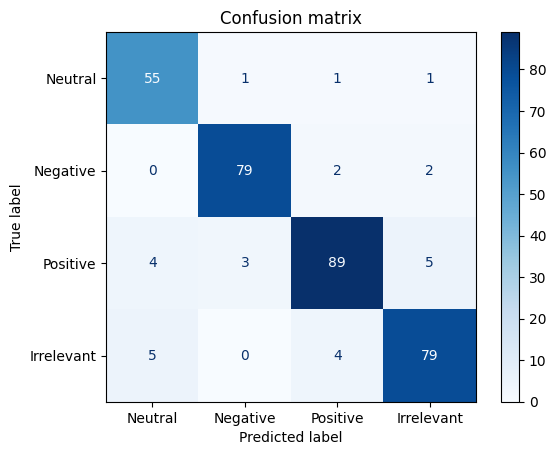

In [21]:
cm = confusion_matrix(y_true_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = y_test.unique())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.show()